## nn

In [3]:
import numpy as np

def format_shape(shape):
    return "x".join(map(str, shape)) if shape else "()"

class Node(object):
    def __repr__(self):
        return "<{} shape={} at {}>".format(
            type(self).__name__, format_shape(self.data.shape), hex(id(self)))

class DataNode(Node):
    """
    DataNode is the parent class for Parameter and Constant nodes.

    You should not need to use this class directly.
    """
    def __init__(self, data):
        self.parents = []
        self.data = data

    def _forward(self, *inputs):
        return self.data

    @staticmethod
    def _backward(gradient, *inputs):
        return []

class Parameter(DataNode):
    """
    A Parameter node stores parameters used in a neural network (or perceptron).

    Use the the `update` method to update parameters when training the
    perceptron or neural network.
    """
    def __init__(self, *shape):
        assert len(shape) == 2, (
            "Shape must have 2 dimensions, instead has {}".format(len(shape)))
        assert all(isinstance(dim, int) and dim > 0 for dim in shape), (
            "Shape must consist of positive integers, got {!r}".format(shape))
        limit = np.sqrt(3.0 / np.mean(shape))
        data = np.random.uniform(low=-limit, high=limit, size=shape)
        super().__init__(data)

    def update(self, direction, multiplier):
        assert isinstance(direction, Constant), (
            "Update direction must be a {} node, instead has type {!r}".format(
                Constant.__name__, type(direction).__name__))
        assert direction.data.shape == self.data.shape, (
            "Update direction shape {} does not match parameter shape "
            "{}".format(
                format_shape(direction.data.shape),
                format_shape(self.data.shape)))
        assert isinstance(multiplier, (int, float)), (
            "Multiplier must be a Python scalar, instead has type {!r}".format(
                type(multiplier).__name__))
        self.data += multiplier * direction.data
        assert np.all(np.isfinite(self.data)), (
            "Parameter contains NaN or infinity after update, cannot continue")

class Constant(DataNode):
    """
    A Constant node is used to represent:
    * Input features
    * Output labels
    * Gradients computed by back-propagation

    You should not need to construct any Constant nodes directly; they will
    instead be provided by either the dataset or when you call `gradients`.
    """
    def __init__(self, data):
        assert isinstance(data, np.ndarray), (
            "Data should be a numpy array, instead has type {!r}".format(
                type(data).__name__))
        assert np.issubdtype(data.dtype, np.floating), (
            "Data should be a float array, instead has data type {!r}".format(
                data.dtype))
        super().__init__(data)

class FunctionNode(Node):
    """
    A FunctionNode represents a value that is computed based on other nodes.
    The FunctionNode class performs necessary book-keeping to compute gradients.
    """
    def __init__(self, *parents):
        assert all(isinstance(parent, Node) for parent in parents), (
            "Inputs must be node objects, instead got types {!r}".format(
                tuple(type(parent).__name__ for parent in parents)))
        self.parents = parents
        self.data = self._forward(*(parent.data for parent in parents))

class Add(FunctionNode):
    """
    Adds matrices element-wise.

    Usage: Add(x, y)
    Inputs:
        x: a Node with shape (batch_size x num_features)
        y: a Node with the same shape as x
    Output:
        a Node with shape (batch_size x num_features)
    """
    @staticmethod
    def _forward(*inputs):
        assert len(inputs) == 2, "Expected 2 inputs, got {}".format(len(inputs))
        assert inputs[0].ndim == 2, (
            "First input should have 2 dimensions, instead has {}".format(
                inputs[0].ndim))
        assert inputs[1].ndim == 2, (
            "Second input should have 2 dimensions, instead has {}".format(
                inputs[1].ndim))
        assert inputs[0].shape == inputs[1].shape, (
            "Input shapes should match, instead got {} and {}".format(
                format_shape(inputs[0].shape), format_shape(inputs[1].shape)))
        return inputs[0] + inputs[1]

    @staticmethod
    def _backward(gradient, *inputs):
        assert gradient.shape == inputs[0].shape
        return [gradient, gradient]

class AddBias(FunctionNode):
    """
    Adds a bias vector to each feature vector

    Usage: AddBias(features, bias)
    Inputs:
        features: a Node with shape (batch_size x num_features)
        bias: a Node with shape (1 x num_features)
    Output:
        a Node with shape (batch_size x num_features)
    """
    @staticmethod
    def _forward(*inputs):
        assert len(inputs) == 2, "Expected 2 inputs, got {}".format(len(inputs))
        assert inputs[0].ndim == 2, (
            "First input should have 2 dimensions, instead has {}".format(
                inputs[0].ndim))
        assert inputs[1].ndim == 2, (
            "Second input should have 2 dimensions, instead has {}".format(
                inputs[1].ndim))
        assert inputs[1].shape[0] == 1, (
            "First dimension of second input should be 1, instead got shape "
            "{}".format(format_shape(inputs[1].shape)))
        assert inputs[0].shape[1] == inputs[1].shape[1], (
            "Second dimension of inputs should match, instead got shapes {} "
            "and {}".format(
                format_shape(inputs[0].shape), format_shape(inputs[1].shape)))
        return inputs[0] + inputs[1]

    @staticmethod
    def _backward(gradient, *inputs):
        assert gradient.shape == inputs[0].shape
        return [gradient, np.sum(gradient, axis=0, keepdims=True)]

class DotProduct(FunctionNode):
    """
    Batched dot product

    Usage: DotProduct(features, weights)
    Inputs:
        features: a Node with shape (batch_size x num_features)
        weights: a Node with shape (1 x num_features)
    Output: a Node with shape (batch_size x 1)
    """
    @staticmethod
    def _forward(*inputs):
        assert len(inputs) == 2, "Expected 2 inputs, got {}".format(len(inputs))
        assert inputs[0].ndim == 2, (
            "First input should have 2 dimensions, instead has {}".format(
                inputs[0].ndim))
        assert inputs[1].ndim == 2, (
            "Second input should have 2 dimensions, instead has {}".format(
                inputs[1].ndim))
        assert inputs[1].shape[0] == 1, (
            "First dimension of second input should be 1, instead got shape "
            "{}".format(format_shape(inputs[1].shape)))
        assert inputs[0].shape[1] == inputs[1].shape[1], (
            "Second dimension of inputs should match, instead got shapes {} "
            "and {}".format(
                format_shape(inputs[0].shape), format_shape(inputs[1].shape)))
        return np.dot(inputs[0], inputs[1].T)

    @staticmethod
    def _backward(gradient, *inputs):
        # assert gradient.shape[0] == inputs[0].shape[0]
        # assert gradient.shape[1] == 1
        # return [np.dot(gradient, inputs[1]), np.dot(gradient.T, inputs[0])]
        raise NotImplementedError(
            "Backpropagation through DotProduct nodes is not needed in this "
            "assignment")

class Linear(FunctionNode):
    """
    Applies a linear transformation (matrix multiplication) to the input

    Usage: Linear(features, weights)
    Inputs:
        features: a Node with shape (batch_size x input_features)
        weights: a Node with shape (input_features x output_features)
    Output: a node with shape (batch_size x output_features)
    """
    @staticmethod
    def _forward(*inputs):
        assert len(inputs) == 2, "Expected 2 inputs, got {}".format(len(inputs))
        assert inputs[0].ndim == 2, (
            "First input should have 2 dimensions, instead has {}".format(
                inputs[0].ndim))
        assert inputs[1].ndim == 2, (
            "Second input should have 2 dimensions, instead has {}".format(
                inputs[1].ndim))
        assert inputs[0].shape[1] == inputs[1].shape[0], (
            "Second dimension of first input should match first dimension of "
            "second input, instead got shapes {} and {}".format(
                format_shape(inputs[0].shape), format_shape(inputs[1].shape)))
        return np.dot(inputs[0], inputs[1])

    @staticmethod
    def _backward(gradient, *inputs):
        assert gradient.shape[0] == inputs[0].shape[0]
        assert gradient.shape[1] == inputs[1].shape[1]
        return [np.dot(gradient, inputs[1].T), np.dot(inputs[0].T, gradient)]

class ReLU(FunctionNode):
    """
    An element-wise Rectified Linear Unit nonlinearity: max(x, 0).
    This nonlinearity replaces all negative entries in its input with zeros.

    Usage: ReLU(x)
    Input:
        x: a Node with shape (batch_size x num_features)
    Output: a Node with the same shape as x, but no negative entries
    """
    @staticmethod
    def _forward(*inputs):
        assert len(inputs) == 1, "Expected 1 input, got {}".format(len(inputs))
        assert inputs[0].ndim == 2, (
            "Input should have 2 dimensions, instead has {}".format(
                inputs[0].ndim))
        return np.maximum(inputs[0], 0)

    @staticmethod
    def _backward(gradient, *inputs):
        assert gradient.shape == inputs[0].shape
        return [gradient * np.where(inputs[0] > 0, 1.0, 0.0)]

class SquareLoss(FunctionNode):
    """
    This node first computes 0.5 * (a[i,j] - b[i,j])**2 at all positions (i,j)
    in the inputs, which creates a (batch_size x dim) matrix. It then calculates
    and returns the mean of all elements in this matrix.

    Usage: SquareLoss(a, b)
    Inputs:
        a: a Node with shape (batch_size x dim)
        b: a Node with shape (batch_size x dim)
    Output: a scalar Node (containing a single floating-point number)
    """
    @staticmethod
    def _forward(*inputs):
        assert len(inputs) == 2, "Expected 2 inputs, got {}".format(len(inputs))
        assert inputs[0].ndim == 2, (
            "First input should have 2 dimensions, instead has {}".format(
                inputs[0].ndim))
        assert inputs[1].ndim == 2, (
            "Second input should have 2 dimensions, instead has {}".format(
                inputs[1].ndim))
        assert inputs[0].shape == inputs[1].shape, (
            "Input shapes should match, instead got {} and {}".format(
                format_shape(inputs[0].shape), format_shape(inputs[1].shape)))
        return np.mean(np.square(inputs[0] - inputs[1]) / 2)

    @staticmethod
    def _backward(gradient, *inputs):
        assert np.asarray(gradient).ndim == 0
        return [
            gradient * (inputs[0] - inputs[1]) / inputs[0].size,
            gradient * (inputs[1] - inputs[0]) / inputs[0].size
        ]

class SoftmaxLoss(FunctionNode):
    """
    A batched softmax loss, used for classification problems.

    IMPORTANT: do not swap the order of the inputs to this node!

    Usage: SoftmaxLoss(logits, labels)
    Inputs:
        logits: a Node with shape (batch_size x num_classes). Each row
            represents the scores associated with that example belonging to a
            particular class. A score can be an arbitrary real number.
        labels: a Node with shape (batch_size x num_classes) that encodes the
            correct labels for the examples. All entries must be non-negative
            and the sum of values along each row should be 1.
    Output: a scalar Node (containing a single floating-point number)
    """
    @staticmethod
    def log_softmax(logits):
        log_probs = logits - np.max(logits, axis=1, keepdims=True)
        log_probs -= np.log(np.sum(np.exp(log_probs), axis=1, keepdims=True))
        return log_probs

    @staticmethod
    def _forward(*inputs):
        assert len(inputs) == 2, "Expected 2 inputs, got {}".format(len(inputs))
        assert inputs[0].ndim == 2, (
            "First input should have 2 dimensions, instead has {}".format(
                inputs[0].ndim))
        assert inputs[1].ndim == 2, (
            "Second input should have 2 dimensions, instead has {}".format(
                inputs[1].ndim))
        assert inputs[0].shape == inputs[1].shape, (
            "Input shapes should match, instead got {} and {}".format(
                format_shape(inputs[0].shape), format_shape(inputs[1].shape)))
        assert np.all(inputs[1] >= 0), (
            "All entries in the labels input must be non-negative")
        assert np.allclose(np.sum(inputs[1], axis=1), 1), (
            "Labels input must sum to 1 along each row")
        log_probs = SoftmaxLoss.log_softmax(inputs[0])
        return np.mean(-np.sum(inputs[1] * log_probs, axis=1))

    @staticmethod
    def _backward(gradient, *inputs):
        assert np.asarray(gradient).ndim == 0
        log_probs = SoftmaxLoss.log_softmax(inputs[0])
        return [
            gradient * (np.exp(log_probs) - inputs[1]) / inputs[0].shape[0],
            gradient * -log_probs / inputs[0].shape[0]
        ]

def gradients(loss, parameters):
    """
    Computes and returns the gradient of the loss with respect to the provided
    parameters.

    Usage: gradients(loss, parameters)
    Inputs:
        loss: a SquareLoss or SoftmaxLoss node
        parameters: a list (or iterable) containing Parameter nodes
    Output: a list of Constant objects, representing the gradient of the loss
        with respect to each provided parameter.
    """

    assert isinstance(loss, (SquareLoss, SoftmaxLoss)), (
        "Loss must be a loss node, instead has type {!r}".format(
            type(loss).__name__))
    assert all(isinstance(parameter, Parameter) for parameter in parameters), (
        "Parameters must all have type {}, instead got types {!r}".format(
            Parameter.__name__,
            tuple(type(parameter).__name__ for parameter in parameters)))
    assert not hasattr(loss, "used"), (
        "Loss node has already been used for backpropagation, cannot reuse")

    loss.used = True

    nodes = set()
    tape = []

    def visit(node):
        if node not in nodes:
            for parent in node.parents:
                visit(parent)
            nodes.add(node)
            tape.append(node)

    visit(loss)
    nodes |= set(parameters)

    grads = {node: np.zeros_like(node.data) for node in nodes}
    grads[loss] = 1.0

    for node in reversed(tape):
        parent_grads = node._backward(
            grads[node], *(parent.data for parent in node.parents))
        for parent, parent_grad in zip(node.parents, parent_grads):
            grads[parent] += parent_grad

    return [Constant(grads[parameter]) for parameter in parameters]

def as_scalar(node):
    """
    Returns the value of a Node as a standard Python number. This only works
    for nodes with one element (e.g. SquareLoss and SoftmaxLoss, as well as
    DotProduct with a batch size of 1 element).
    """

    assert isinstance(node, Node), (
        "Input must be a node object, instead has type {!r}".format(
            type(node).__name__))
    assert node.data.size == 1, (
        "Node has shape {}, cannot convert to a scalar".format(
            format_shape(node.data.shape)))
    # print(node.data[0])
    return node.data[0][0]


## models

In [5]:
class PerceptronModel(object):
    def __init__(self, dimensions):
        """
        Initialize a new Perceptron instance.

        A perceptron classifies data points as either belonging to a particular
        class (+1) or not (-1). `dimensions` is the dimensionality of the data.
        For example, dimensions=2 would mean that the perceptron must classify
        2D points.
        """
        self.w = Parameter(1, dimensions)

    def get_weights(self):
        """
        Return a Parameter instance with the current weights of the perceptron.
        """
        return self.w

    def run(self, x):
        """
        Calculates the score assigned by the perceptron to a data point x.

        Inputs:
            x: a node with shape (1 x dimensions)
        Returns: a node containing a single number (the score)
        """
        "*** YOUR CODE HERE ***"
        return DotProduct(x, self.get_weights())

    def get_prediction(self, x):
        """
        Calculates the predicted class for a single data point `x`.

        Returns: 1 or -1
        """
        "*** YOUR CODE HERE ***"
        return 1 if as_scalar(self.run(x)) >= 0 else -1

    def train(self, dataset: Dataset):
        """
        Train the perceptron until convergence.
        """
        "*** YOUR CODE HERE ***"
        "Use Stachostic GD, so evaluation and param modification will based on each data point."
        isAllCorrect = False

        while not isAllCorrect:
            isAllCorrect = True

            for x, y in dataset.iterate_once(1):
                y = as_scalar(y)
                if self.get_prediction(x) != y:
                    self.get_weights().update(x, y) # w -= x*y
                    isAllCorrect = False


class RegressionModel(object):
    """
    A neural network model for approximating a function that maps from real
    numbers to real numbers. The network should be sufficiently large to be able
    to approximate sin(x) on the interval [-2pi, 2pi] to reasonable precision.
    """
    def __init__(self):
        # Initialize your model parameters here
        "*** YOUR CODE HERE ***"
        hidden_layer_size = 88 # equivalent to number of output features
        # 1 hidden layer (has weights denoted by w1 matrix)
        self.w1 = Parameter(1, hidden_layer_size)
        self.b1 = Parameter(1, hidden_layer_size)
        # 1 node in output layer (has weights denoted by w2 matrix)
        self.w2 = Parameter(hidden_layer_size, 1)
        self.b2 = Parameter(1, 1)

    def run(self, x):
        """
        Runs the model for a batch of examples.

        Inputs:
            x: a node with shape (batch_size x 1)
        Returns:
            A node with shape (batch_size x 1) containing predicted y-values
        """
        "*** YOUR CODE HERE ***"
        linear_multi = Linear(x, self.w1)
        z1 = AddBias(linear_multi, self.b1)
        a1 = ReLU(z1)

        linear_multi = Linear(a1, self.w2)
        z2 = AddBias(linear_multi, self.b2)

        return z2

    def get_loss(self, x, y):
        """
        Computes the loss for a batch of examples.

        Inputs:
            x: a node with shape (batch_size x 1)
            y: a node with shape (batch_size x 1), containing the true y-values
                to be used for training
        Returns: a loss node
        """
        "*** YOUR CODE HERE ***"
        predicted_y = self.run(x)
        return SquareLoss(predicted_y, y)


    def train(self, dataset: Dataset):
        """
        Trains the model.
        """
        "*** YOUR CODE HERE ***"
        batch_size = dataset.x.shape[0]
        learning_rate = 0.03

        batch_number = 0
        epoch = 0

        def isAcceptable(loss_obj):
            loss_function_value = loss_obj.data
            # Final loss must be no more than 0.02 (set by autograder)
            return True if loss_function_value <= 0.02 else False


        # evaluate by loss function and modify params by GD on total dataset
        for x, y in dataset.iterate_forever(batch_size):
            batch_number = batch_number % 100 + 1
            if batch_number == 1:
                epoch += 1
                print("Epoch: %s" % epoch)

            params = [self.w1, self.w2, self.b1, self.b2]
            gradients = gradients(self.get_loss(x, y), params)

            for i in range(len(gradients)):
                params[i].update(gradients[i], -(learning_rate))


            if isAcceptable(self.get_loss(x, y)):
                return


class DigitClassificationModel(object):
    """
    A model for handwritten digit classification using the MNIST dataset.

    Each handwritten digit is a 28x28 pixel grayscale image, which is flattened
    into a 784-dimensional vector for the purposes of this model. Each entry in
    the vector is a floating point number between 0 and 1.

    The goal is to sort each digit into one of 10 classes (number 0 through 9).

    (See RegressionModel for more information about the APIs of different
    methods here. We recommend that you implement the RegressionModel before
    working on this part of the project.)
    """
    def __init__(self):
        # Initialize your model parameters here
        "*** YOUR CODE HERE ***"
        self.w1 = Parameter(784, 256)
        self.b1 = Parameter(1, 256)
        self.w2 = Parameter(256, 128)
        self.b2 = Parameter(1, 128)
        self.w3 = Parameter(128, 10)
        self.b3 = Parameter(1, 10)

    def run(self, x):
        """
        Runs the model for a batch of examples.

        Your model should predict a node with shape (batch_size x 10),
        containing scores. Higher scores correspond to greater probability of
        the image belonging to a particular class.

        Inputs:
            x: a node with shape (batch_size x 784)
        Output:
            A node with shape (batch_size x 10) containing predicted scores
                (also called logits)
        """
        "*** YOUR CODE HERE ***"
        linear_multi = Linear(x, self.w1)
        z1 = AddBias(linear_multi, self.b1)
        a1 = ReLU(z1)

        linear_multi = Linear(a1, self.w2)
        z2 = AddBias(linear_multi, self.b2)
        a2 = ReLU(z2)

        linear_multi = Linear(a2, self.w3)
        z3 = AddBias(linear_multi, self.b3)

        return z3

    def get_loss(self, x, y):
        """
        Computes the loss for a batch of examples.

        The correct labels `y` are represented as a node with shape
        (batch_size x 10). Each row is a one-hot vector encoding the correct
        digit class (0-9).

        Inputs:
            x: a node with shape (batch_size x 784)
            y: a node with shape (batch_size x 10)
        Returns: a loss node
        """
        "*** YOUR CODE HERE ***"
        prediction = self.run(x)
        return SoftmaxLoss(prediction, y)


    def train(self, dataset: Dataset):
        """
        Trains the model.
        """
        "*** YOUR CODE HERE ***"
        learning_rate = 0.2
        batch_size = int(dataset.x.shape[0] / 100)

        batch_number = 0
        epoch = 0

        def isAcceptable(loss):
            loss_value = loss.data
            return True if loss_value < 0.015 else False


        for x, y in dataset.iterate_forever(batch_size):
            batch_number = batch_number % 100 + 1
            if batch_number == 1:
                epoch += 1
                print("Epoch: %s" % epoch)

            params_list = [self.w1, self.b1, self.w2, self.b2, self.w3, self.b3]
            local_v_gradients = gradients(self.get_loss(x, y), params_list)

            for i in range(len(params_list)):
                params_list[i].update(local_v_gradients[i], -(learning_rate)) #param -= gradient * learning_rate

            if isAcceptable(self.get_loss(x, y)):
                return

class LanguageIDModel(object):
    """
    A model for language identification at a single-word granularity.

    (See RegressionModel for more information about the APIs of different
    methods here. We recommend that you implement the RegressionModel before
    working on this part of the project.)
    """
    def __init__(self):
        # Our dataset contains words from five different languages, and the
        # combined alphabets of the five languages contain a total of 47 unique
        # characters.
        # You can refer to self.num_chars or len(self.languages) in your code
        self.num_chars = 47
        self.languages = ["English", "Spanish", "Finnish", "Dutch", "Polish"]

        # Initialize your model parameters here
        "*** YOUR CODE HERE ***"

    def run(self, xs):
        """
        Runs the model for a batch of examples.

        Although words have different lengths, our data processing guarantees
        that within a single batch, all words will be of the same length (L).

        Here `xs` will be a list of length L. Each element of `xs` will be a
        node with shape (batch_size x self.num_chars), where every row in the
        array is a one-hot vector encoding of a character. For example, if we
        have a batch of 8 three-letter words where the last word is "cat", then
        xs[1] will be a node that contains a 1 at position (7, 0). Here the
        index 7 reflects the fact that "cat" is the last word in the batch, and
        the index 0 reflects the fact that the letter "a" is the inital (0th)
        letter of our combined alphabet for this task.

        Your model should use a Recurrent Neural Network to summarize the list
        `xs` into a single node of shape (batch_size x hidden_size), for your
        choice of hidden_size. It should then calculate a node of shape
        (batch_size x 5) containing scores, where higher scores correspond to
        greater probability of the word originating from a particular language.

        Inputs:
            xs: a list with L elements (one per character), where each element
                is a node with shape (batch_size x self.num_chars)
        Returns:
            A node with shape (batch_size x 5) containing predicted scores
                (also called logits)
        """
        "*** YOUR CODE HERE ***"

    def get_loss(self, xs, y):
        """
        Computes the loss for a batch of examples.

        The correct labels `y` are represented as a node with shape
        (batch_size x 5). Each row is a one-hot vector encoding the correct
        language.

        Inputs:
            xs: a list with L elements (one per character), where each element
                is a node with shape (batch_size x self.num_chars)
            y: a node with shape (batch_size x 5)
        Returns: a loss node
        """
        "*** YOUR CODE HERE ***"

    def train(self, dataset):
        """
        Trains the model.
        """
        "*** YOUR CODE HERE ***"


## backend

### class Dataset (must be run before models)

In [4]:
class Dataset(object):
    def __init__(self, x, y):
        assert isinstance(x, np.ndarray)
        assert isinstance(y, np.ndarray)
        assert np.issubdtype(x.dtype, np.floating)
        assert np.issubdtype(y.dtype, np.floating)
        assert x.ndim == 2
        assert y.ndim == 2
        assert x.shape[0] == y.shape[0]
        self.x = x
        self.y = y

    def iterate_once(self, batch_size):
        assert isinstance(batch_size, int) and batch_size > 0, (
            "Batch size should be a positive integer, got {!r}".format(
                batch_size))
        assert self.x.shape[0] % batch_size == 0, (
            "Dataset size {:d} is not divisible by batch size {:d}".format(
                self.x.shape[0], batch_size))
        index = 0
        while index < self.x.shape[0]:
            x = self.x[index:index + batch_size]
            y = self.y[index:index + batch_size]
            yield Constant(x), Constant(y)
            index += batch_size

    def iterate_forever(self, batch_size):
        while True:
            yield from self.iterate_once(batch_size)

    def get_validation_accuracy(self):
        raise NotImplementedError(
            "No validation data is available for this dataset. "
            "In this assignment, only the Digit Classification and Language "
            "Identification datasets have validation data.")


### Importing & utility functions

In [6]:
import collections
import os
import time
import os

import matplotlib.pyplot as plt
import numpy as np

# import nn

In [7]:
use_graphics = True

def maybe_sleep_and_close(seconds):
    if use_graphics and plt.get_fignums():
        time.sleep(seconds)
        for fignum in plt.get_fignums():
            fig = plt.figure(fignum)
            plt.close(fig)
            try:
                # This raises a TclError on some Windows machines
                fig.canvas.start_event_loop(1e-3)
            except:
                pass

def get_data_path(filename):
    # path = os.path.join(
    #     os.path.dirname(__file__), os.pardir, "data", filename)
    path = os.path.join(
            "/content/drive/Othercomputers", "My Laptop", "machinelearning/data", filename)

    # if not os.path.exists(path):
    #     path = os.path.join(
    #         os.path.dirname(__file__), "data", filename)
    # if not os.path.exists(path):
    #     path = os.path.join(
    #         os.path.dirname(__file__), filename)

    if not os.path.exists(path):
        raise Exception("Could not find data file: {}".format(filename))
    return path

### Dataset inheritors

In [8]:
# class Dataset(object):
#     def __init__(self, x, y):
#         assert isinstance(x, np.ndarray)
#         assert isinstance(y, np.ndarray)
#         assert np.issubdtype(x.dtype, np.floating)
#         assert np.issubdtype(y.dtype, np.floating)
#         assert x.ndim == 2
#         assert y.ndim == 2
#         assert x.shape[0] == y.shape[0]
#         self.x = x
#         self.y = y

#     def iterate_once(self, batch_size):
#         assert isinstance(batch_size, int) and batch_size > 0, (
#             "Batch size should be a positive integer, got {!r}".format(
#                 batch_size))
#         assert self.x.shape[0] % batch_size == 0, (
#             "Dataset size {:d} is not divisible by batch size {:d}".format(
#                 self.x.shape[0], batch_size))
#         index = 0
#         while index < self.x.shape[0]:
#             x = self.x[index:index + batch_size]
#             y = self.y[index:index + batch_size]
#             yield Constant(x), Constant(y)
#             index += batch_size

#     def iterate_forever(self, batch_size):
#         while True:
#             yield from self.iterate_once(batch_size)

#     def get_validation_accuracy(self):
#         raise NotImplementedError(
#             "No validation data is available for this dataset. "
#             "In this assignment, only the Digit Classification and Language "
#             "Identification datasets have validation data.")

class PerceptronDataset(Dataset):
    def __init__(self, model):
        points = 500
        x = np.hstack([np.random.randn(points, 2), np.ones((points, 1))])
        y = np.where(x[:, 0] + 2 * x[:, 1] - 1 >= 0, 1.0, -1.0)
        super().__init__(x, np.expand_dims(y, axis=1))

        self.model = model
        self.epoch = 0

        if use_graphics:
            fig, ax = plt.subplots(1, 1)
            limits = np.array([-3.0, 3.0])
            ax.set_xlim(limits)
            ax.set_ylim(limits)
            positive = ax.scatter(*x[y == 1, :-1].T, color="red", marker="+")
            negative = ax.scatter(*x[y == -1, :-1].T, color="blue", marker="_")
            line, = ax.plot([], [], color="black")
            text = ax.text(0.03, 0.97, "", transform=ax.transAxes, va="top")
            ax.legend([positive, negative], [1, -1])
            plt.show(block=False)

            self.fig = fig
            self.limits = limits
            self.line = line
            self.text = text
            self.last_update = time.time()

    def iterate_once(self, batch_size):
        self.epoch += 1

        for i, (x, y) in enumerate(super().iterate_once(batch_size)):
            yield x, y

            if use_graphics and time.time() - self.last_update > 0.01:
                w = self.model.get_weights().data.flatten()
                limits = self.limits
                if w[1] != 0:
                    self.line.set_data(limits, (-w[0] * limits - w[2]) / w[1])
                elif w[0] != 0:
                    self.line.set_data(np.full(2, -w[2] / w[0]), limits)
                else:
                    self.line.set_data([], [])
                self.text.set_text(
                    "epoch: {:,}\npoint: {:,}/{:,}\nweights: {}".format(
                        self.epoch, i * batch_size + 1, len(self.x), w))
                self.fig.canvas.draw_idle()
                self.fig.canvas.start_event_loop(1e-3)
                self.last_update = time.time()

class RegressionDataset(Dataset):
    def __init__(self, model):
        x = np.expand_dims(np.linspace(-2 * np.pi, 2 * np.pi, num=200), axis=1)
        np.random.RandomState(0).shuffle(x)
        self.argsort_x = np.argsort(x.flatten())
        y = np.sin(x)
        super().__init__(x, y)

        self.model = model
        self.processed = 0

        if use_graphics:
            fig, ax = plt.subplots(1, 1)
            ax.set_xlim(-2 * np.pi, 2 * np.pi)
            ax.set_ylim(-1.4, 1.4)
            real, = ax.plot(x[self.argsort_x], y[self.argsort_x], color="blue")
            learned, = ax.plot([], [], color="red")
            text = ax.text(0.03, 0.97, "", transform=ax.transAxes, va="top")
            ax.legend([real, learned], ["real", "learned"])
            plt.show(block=False)

            self.fig = fig
            self.learned = learned
            self.text = text
            self.last_update = time.time()

    def iterate_once(self, batch_size):
        for x, y in super().iterate_once(batch_size):
            yield x, y
            self.processed += batch_size

            if use_graphics and time.time() - self.last_update > 0.1:
                predicted = self.model.run(Constant(self.x)).data
                loss = self.model.get_loss(
                    Constant(self.x), Constant(self.y)).data
                self.learned.set_data(self.x[self.argsort_x], predicted[self.argsort_x])
                self.text.set_text("processed: {:,}\nloss: {:.6f}".format(
                   self.processed, loss))
                self.fig.canvas.draw_idle()
                self.fig.canvas.start_event_loop(1e-3)
                self.last_update = time.time()

class DigitClassificationDataset(Dataset):
    def __init__(self, model):
        mnist_path = get_data_path("mnist.npz")

        with np.load(mnist_path) as data:
            train_images = data["train_images"]
            train_labels = data["train_labels"]
            test_images = data["test_images"]
            test_labels = data["test_labels"]
            assert len(train_images) == len(train_labels) == 60000
            assert len(test_images) == len(test_labels) == 10000
            self.dev_images = test_images[0::2]
            self.dev_labels = test_labels[0::2]
            self.test_images = test_images[1::2]
            self.test_labels = test_labels[1::2]

        train_labels_one_hot = np.zeros((len(train_images), 10))
        train_labels_one_hot[range(len(train_images)), train_labels] = 1

        super().__init__(train_images, train_labels_one_hot)

        self.model = model
        self.epoch = 0

        if use_graphics:
            width = 20  # Width of each row expressed as a multiple of image width
            samples = 100  # Number of images to display per label
            fig = plt.figure()
            ax = {}
            images = collections.defaultdict(list)
            texts = collections.defaultdict(list)
            for i in reversed(range(10)):
                ax[i] = plt.subplot2grid((30, 1), (3 * i, 0), 2, 1,
                                         sharex=ax.get(9))
                plt.setp(ax[i].get_xticklabels(), visible=i == 9)
                ax[i].set_yticks([])
                ax[i].text(-0.03, 0.5, i, transform=ax[i].transAxes,
                           va="center")
                ax[i].set_xlim(0, 28 * width)
                ax[i].set_ylim(0, 28)
                for j in range(samples):
                    images[i].append(ax[i].imshow(
                        np.zeros((28, 28)), vmin=0, vmax=1, cmap="Greens",
                        alpha=0.3))
                    texts[i].append(ax[i].text(
                        0, 0, "", ha="center", va="top", fontsize="smaller"))
            ax[9].set_xticks(np.linspace(0, 28 * width, 11))
            ax[9].set_xticklabels(
                ["{:.1f}".format(num) for num in np.linspace(0, 1, 11)])
            ax[9].tick_params(axis="x", pad=16)
            ax[9].set_xlabel("Probability of Correct Label")
            status = ax[0].text(
                0.5, 1.5, "", transform=ax[0].transAxes, ha="center",
                va="bottom")
            plt.show(block=False)

            self.width = width
            self.samples = samples
            self.fig = fig
            self.images = images
            self.texts = texts
            self.status = status
            self.last_update = time.time()

    def iterate_once(self, batch_size):
        self.epoch += 1

        for i, (x, y) in enumerate(super().iterate_once(batch_size)):
            yield x, y

            if use_graphics and time.time() - self.last_update > 1:
                dev_logits = self.model.run(Constant(self.dev_images)).data
                dev_predicted = np.argmax(dev_logits, axis=1)
                dev_probs = np.exp(SoftmaxLoss.log_softmax(dev_logits))
                dev_accuracy = np.mean(dev_predicted == self.dev_labels)

                self.status.set_text(
                    "epoch: {:d}, batch: {:d}/{:d}, validation accuracy: "
                    "{:.2%}".format(
                        self.epoch, i, len(self.x) // batch_size, dev_accuracy))
                for i in range(10):
                    predicted = dev_predicted[self.dev_labels == i]
                    probs = dev_probs[self.dev_labels == i][:, i]
                    linspace = np.linspace(
                        0, len(probs) - 1, self.samples).astype(int)
                    indices = probs.argsort()[linspace]
                    for j, (prob, image) in enumerate(zip(
                            probs[indices],
                            self.dev_images[self.dev_labels == i][indices])):
                        self.images[i][j].set_data(image.reshape((28, 28)))
                        left = prob * (self.width - 1) * 28
                        if predicted[indices[j]] == i:
                            self.images[i][j].set_cmap("Greens")
                            self.texts[i][j].set_text("")
                        else:
                            self.images[i][j].set_cmap("Reds")
                            self.texts[i][j].set_text(predicted[indices[j]])
                            self.texts[i][j].set_x(left + 14)
                        self.images[i][j].set_extent([left, left + 28, 0, 28])
                self.fig.canvas.draw_idle()
                self.fig.canvas.start_event_loop(1e-3)
                self.last_update = time.time()

    def get_validation_accuracy(self):
        dev_logits = self.model.run(Constant(self.dev_images)).data
        dev_predicted = np.argmax(dev_logits, axis=1)
        dev_accuracy = np.mean(dev_predicted == self.dev_labels)
        return dev_accuracy

class LanguageIDDataset(Dataset):
    def __init__(self, model):
        self.model = model

        data_path = get_data_path("lang_id.npz")

        with np.load(data_path) as data:
            self.chars = data['chars']
            self.language_codes = data['language_codes']
            self.language_names = data['language_names']

            self.train_x = data['train_x']
            self.train_y = data['train_y']
            self.train_buckets = data['train_buckets']
            self.dev_x = data['dev_x']
            self.dev_y = data['dev_y']
            self.dev_buckets = data['dev_buckets']
            self.test_x = data['test_x']
            self.test_y = data['test_y']
            self.test_buckets = data['test_buckets']

        self.epoch = 0
        self.bucket_weights = self.train_buckets[:,1] - self.train_buckets[:,0]
        self.bucket_weights = self.bucket_weights / float(self.bucket_weights.sum())

        self.chars_print = self.chars
        try:
            print(u"Alphabet: {}".format(u"".join(self.chars)))
        except UnicodeEncodeError:
            self.chars_print = "abcdefghijklmnopqrstuvwxyzaaeeeeiinoouuacelnszz"
            print("Alphabet: " + self.chars_print)
            self.chars_print = list(self.chars_print)
            print("""
NOTE: Your terminal does not appear to support printing Unicode characters.
For the purposes of printing to the terminal, some of the letters in the
alphabet above have been substituted with ASCII symbols.""".strip())
        print("")

        # Select some examples to spotlight in the monitoring phase (3 per language)
        spotlight_idxs = []
        for i in range(len(self.language_names)):
            idxs_lang_i = np.nonzero(self.dev_y == i)[0]
            idxs_lang_i = np.random.choice(idxs_lang_i, size=3, replace=False)
            spotlight_idxs.extend(list(idxs_lang_i))
        self.spotlight_idxs = np.array(spotlight_idxs, dtype=int)

        # Templates for printing updates as training progresses
        max_word_len = self.dev_x.shape[1]
        max_lang_len = max([len(x) for x in self.language_names])

        self.predicted_template = u"Pred: {:<NUM}".replace('NUM',
            str(max_lang_len))

        self.word_template = u"  "
        self.word_template += u"{:<NUM} ".replace('NUM', str(max_word_len))
        self.word_template += u"{:<NUM} ({:6.1%})".replace('NUM', str(max_lang_len))
        self.word_template += u" {:<NUM} ".replace('NUM',
            str(max_lang_len + len('Pred: ')))
        for i in range(len(self.language_names)):
            self.word_template += u"|{}".format(self.language_codes[i])
            self.word_template += "{probs[" + str(i) + "]:4.0%}"

        self.last_update = time.time()

    def _encode(self, inp_x, inp_y):
        xs = []
        for i in range(inp_x.shape[1]):
            if np.all(inp_x[:,i] == -1):
                break
            assert not np.any(inp_x[:,i] == -1), (
                "Please report this error in the project: batching by length was done incorrectly in the provided code")
            x = np.eye(len(self.chars))[inp_x[:,i]]
            xs.append(Constant(x))
        y = np.eye(len(self.language_names))[inp_y]
        y = Constant(y)
        return xs, y

    def _softmax(self, x):
        exp = np.exp(x - np.max(x, axis=-1, keepdims=True))
        return exp / np.sum(exp, axis=-1, keepdims=True)

    def _predict(self, split='dev'):
        if split == 'dev':
            data_x = self.dev_x
            data_y = self.dev_y
            buckets = self.dev_buckets
        else:
            data_x = self.test_x
            data_y = self.test_y
            buckets = self.test_buckets

        all_predicted = []
        all_correct = []
        for bucket_id in range(buckets.shape[0]):
            start, end = buckets[bucket_id]
            xs, y = self._encode(data_x[start:end], data_y[start:end])
            predicted = self.model.run(xs)

            all_predicted.extend(list(predicted.data))
            all_correct.extend(list(data_y[start:end]))

        all_predicted_probs = self._softmax(np.asarray(all_predicted))
        all_predicted = np.asarray(all_predicted).argmax(axis=-1)
        all_correct = np.asarray(all_correct)

        return all_predicted_probs, all_predicted, all_correct

    def iterate_once(self, batch_size):
        assert isinstance(batch_size, int) and batch_size > 0, (
            "Batch size should be a positive integer, got {!r}".format(
                batch_size))
        assert self.train_x.shape[0] >= batch_size, (
            "Dataset size {:d} is smaller than the batch size {:d}".format(
                self.train_x.shape[0], batch_size))

        self.epoch += 1

        for iteration in range(self.train_x.shape[0] // batch_size):
            bucket_id = np.random.choice(self.bucket_weights.shape[0], p=self.bucket_weights)
            example_ids = self.train_buckets[bucket_id, 0] + np.random.choice(
                self.train_buckets[bucket_id, 1] - self.train_buckets[bucket_id, 0],
                size=batch_size)

            yield self._encode(self.train_x[example_ids], self.train_y[example_ids])

            if use_graphics and time.time() - self.last_update > 0.5:
                dev_predicted_probs, dev_predicted, dev_correct = self._predict()
                dev_accuracy = np.mean(dev_predicted == dev_correct)

                print("epoch {:,} iteration {:,} validation-accuracy {:.1%}".format(
                    self.epoch, iteration, dev_accuracy))

                for idx in self.spotlight_idxs:
                    correct = (dev_predicted[idx] == dev_correct[idx])
                    word = u"".join([self.chars_print[ch] for ch in self.dev_x[idx] if ch != -1])

                    print(self.word_template.format(
                        word,
                        self.language_names[dev_correct[idx]],
                        dev_predicted_probs[idx, dev_correct[idx]],
                        "" if correct else self.predicted_template.format(
                            self.language_names[dev_predicted[idx]]),
                        probs=dev_predicted_probs[idx,:],
                    ))

                self.last_update = time.time()

    def get_validation_accuracy(self):
        dev_predicted_probs, dev_predicted, dev_correct = self._predict()
        dev_accuracy = np.mean(dev_predicted == dev_correct)
        return dev_accuracy




## Test for correct execution with main() function

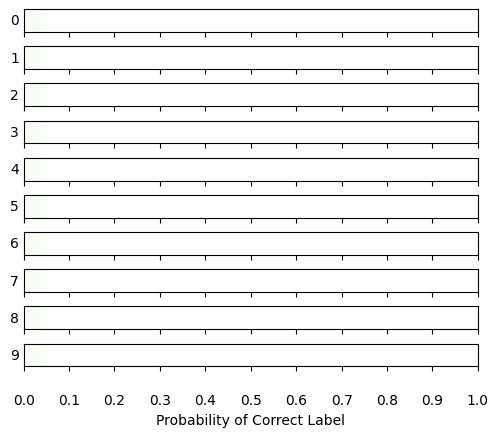

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17


In [9]:
def main():
    # import models
    # model = PerceptronModel(3)
    # dataset = PerceptronDataset(model)
    # model.train(dataset)

    # model = RegressionModel()
    # dataset = RegressionDataset(model)
    # model.train(dataset)

    model = DigitClassificationModel()
    dataset = DigitClassificationDataset(model)
    model.train(dataset)

    # model = LanguageIDModel()
    # dataset = LanguageIDDataset(model)
    # model.train(dataset)

if __name__ == "__main__":
    main()